In [15]:
#@title Import Dependencies

import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Enable interactive plotting
%matplotlib inline

In [16]:
#@title Define Hyperparameters

input_size = 784 # img_size = (28,28) ---> 28*28=784 in total
hidden_size = 500 # number of nodes at hidden layer
num_classes = 10 # number of output classes discrete range [0,9]
num_epochs = 20 # number of times which the entire dataset is passed throughout the model
batch_size = 100 # the size of input data took for one iteration
lr = 1e-3 # size of step

In [17]:
#@title Downloading MNIST data

train_data = dsets.MNIST(root = './data', train = True,
                        transform = transforms.ToTensor(), download = True)

test_data = dsets.MNIST(root = './data', train = False,
                       transform = transforms.ToTensor())

In [18]:
#@title Loading the data

train_gen = torch.utils.data.DataLoader(dataset = train_data,
                                             batch_size = batch_size,
                                             shuffle = True)

test_gen = torch.utils.data.DataLoader(dataset = test_data,
                                      batch_size = batch_size,
                                      shuffle = False)

In [19]:
#@title Define model class

class Net(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super(Net,self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(hidden_size, num_classes)

  def forward(self,x):
    out = self.fc1(x)
    out = self.relu(out)
    out = self.fc2(out)
    return out

In [20]:
#@title Build the model

net = Net(input_size, hidden_size, num_classes)
net

Net(
  (fc1): Linear(in_features=784, out_features=500, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [21]:
#@title Define loss-function & optimizer

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam( net.parameters(), lr=lr)

In [22]:
#@title Training the model with live visualization

# Lists to store metrics
train_losses = []
test_losses = []
test_accuracies = []
epochs_list = []

# Function to evaluate on test set
def evaluate_model():
    net.eval()
    correct = 0
    total = 0
    total_loss = 0
    
    with torch.no_grad():
        for images, labels in test_gen:
            images = Variable(images.view(-1, 28*28))
            labels = Variable(labels)
            
            outputs = net(images)
            loss = loss_function(outputs, labels)
            total_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_loss = total_loss / len(test_gen)
    accuracy = 100 * correct / total
    net.train()
    return avg_loss, accuracy

# Function to plot metrics
def plot_metrics():
    clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
    
    # Plot losses
    ax1.plot(epochs_list, train_losses, 'b-', label='Train Loss', linewidth=2)
    ax1.plot(epochs_list, test_losses, 'r-', label='Test Loss', linewidth=2)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title('Training and Test Loss', fontsize=14)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot accuracy
    ax2.plot(epochs_list, test_accuracies, 'g-', linewidth=2)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy (%)', fontsize=12)
    ax2.set_title('Test Accuracy', fontsize=14)
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim([0, 100])
    
    plt.tight_layout()
    plt.show()
    
# Training loop
for epoch in range(num_epochs):
    net.train()
    epoch_loss = 0
    num_batches = 0
    
    for i, (images, labels) in enumerate(train_gen):
        images = Variable(images.view(-1, 28*28))
        labels = Variable(labels)
        
        optimizer.zero_grad()
        outputs = net(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
        
        if (i+1) % 100 == 0:
            print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
                  %(epoch+1, num_epochs, i+1, len(train_data)//batch_size, loss.item()))
    
    # Calculate average training loss for the epoch
    avg_train_loss = epoch_loss / num_batches
    
    # Evaluate on test set
    test_loss, test_accuracy = evaluate_model()
    
    # Store metrics
    epochs_list.append(epoch + 1)
    train_losses.append(avg_train_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    
    # Plot metrics
    plot_metrics()
    print(f'\nEpoch [{epoch+1}/{num_epochs}] Summary:')
    print(f'  Train Loss: {avg_train_loss:.4f}')
    print(f'  Test Loss: {test_loss:.4f}')
    print(f'  Test Accuracy: {test_accuracy:.2f}%\n')


Epoch [20/20] Summary:
  Train Loss: 0.0022
  Test Loss: 0.0848
  Test Accuracy: 98.17%



FINAL MODEL PERFORMANCE
Best Test Accuracy: 98.23%
Final Test Accuracy: 98.17%
Final Train Loss: 0.0022
Final Test Loss: 0.0848


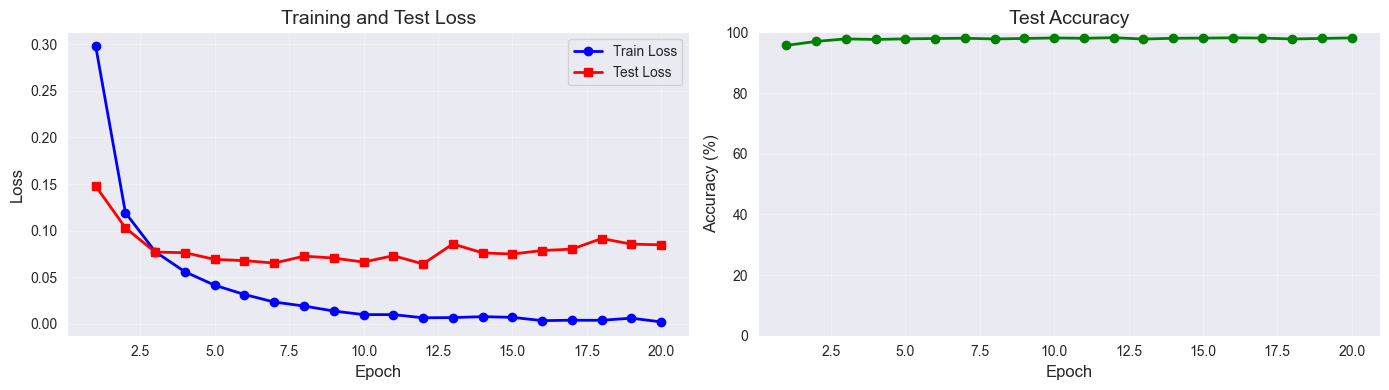

In [23]:
#@title Final Evaluation Summary

print('='*60)
print('FINAL MODEL PERFORMANCE')
print('='*60)
print(f'Best Test Accuracy: {max(test_accuracies):.2f}%')
print(f'Final Test Accuracy: {test_accuracies[-1]:.2f}%')
print(f'Final Train Loss: {train_losses[-1]:.4f}')
print(f'Final Test Loss: {test_losses[-1]:.4f}')
print('='*60)

# Re-plot final metrics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

# Plot losses
ax1.plot(epochs_list, train_losses, 'b-', label='Train Loss', linewidth=2, marker='o')
ax1.plot(epochs_list, test_losses, 'r-', label='Test Loss', linewidth=2, marker='s')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training and Test Loss', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot accuracy
ax2.plot(epochs_list, test_accuracies, 'g-', linewidth=2, marker='o')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_title('Test Accuracy', fontsize=14)
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0, 100])

plt.tight_layout()
plt.show()

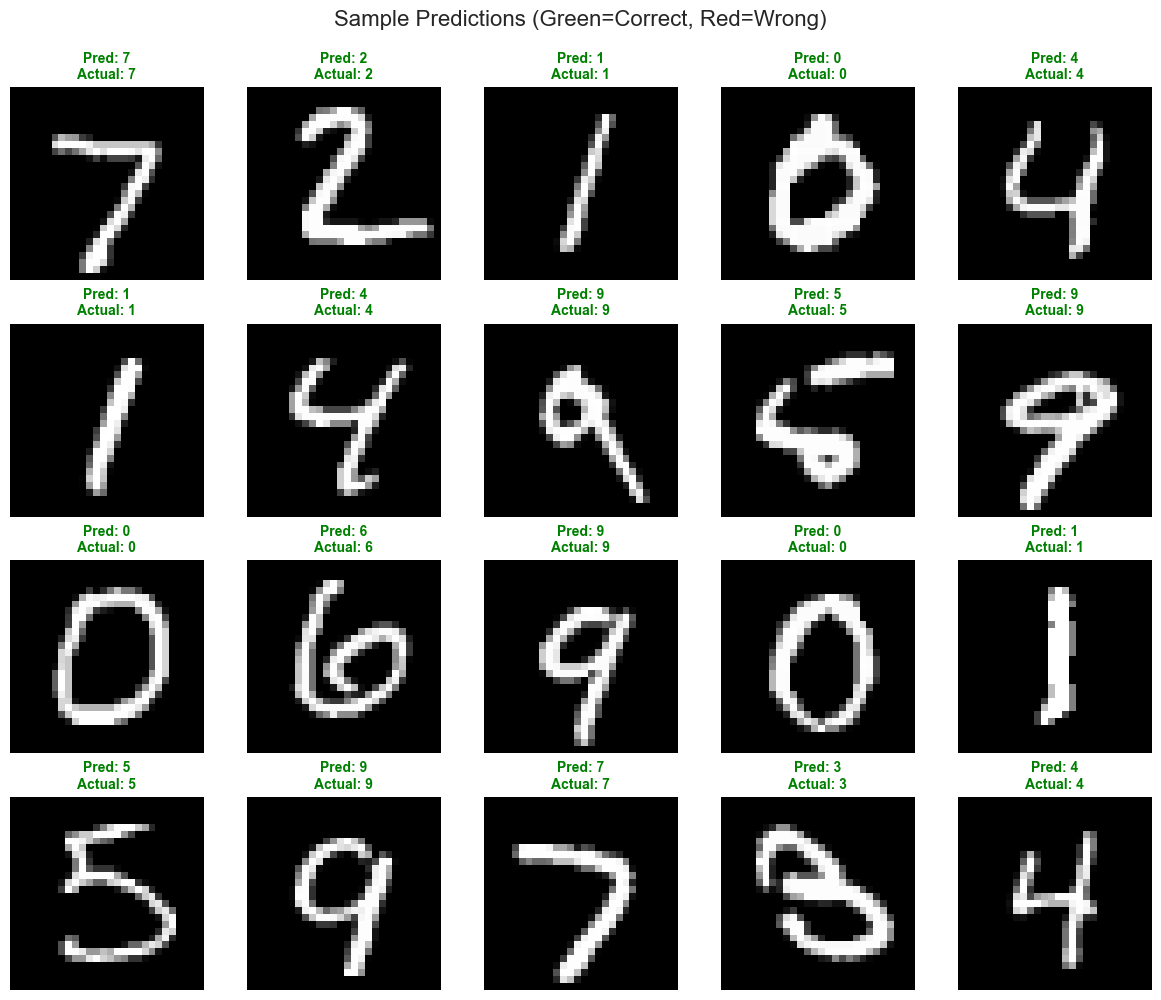


Batch Statistics:
Correct predictions: 100/100 (100.0%)


In [24]:
#@title Visualize Sample Predictions

import numpy as np

# Get a batch of test images
dataiter = iter(test_gen)
images, labels = next(dataiter)

# Make predictions
net.eval()
with torch.no_grad():
    images_flat = Variable(images.view(-1, 28*28))
    outputs = net(images_flat)
    _, predicted = torch.max(outputs.data, 1)

# Convert to numpy for plotting
images_np = images.numpy()
predicted_np = predicted.numpy()
labels_np = labels.numpy()

# Plot 20 samples (4 rows x 5 columns)
fig, axes = plt.subplots(4, 5, figsize=(12, 10))
fig.suptitle('Sample Predictions (Green=Correct, Red=Wrong)', fontsize=16, y=0.995)

for idx, ax in enumerate(axes.flat):
    if idx < len(images_np):
        # Display image
        ax.imshow(images_np[idx].squeeze(), cmap='gray')
        
        # Check if prediction is correct
        is_correct = predicted_np[idx] == labels_np[idx]
        color = 'green' if is_correct else 'red'
        
        # Set title with prediction and actual label
        title = f'Pred: {predicted_np[idx]}\nActual: {labels_np[idx]}'
        ax.set_title(title, fontsize=10, color=color, weight='bold')
        ax.axis('off')

plt.tight_layout()
plt.show()

# Print summary statistics for this batch
num_correct = (predicted_np == labels_np).sum()
print(f'\nBatch Statistics:')
print(f'Correct predictions: {num_correct}/{len(labels_np)} ({100*num_correct/len(labels_np):.1f}%)')


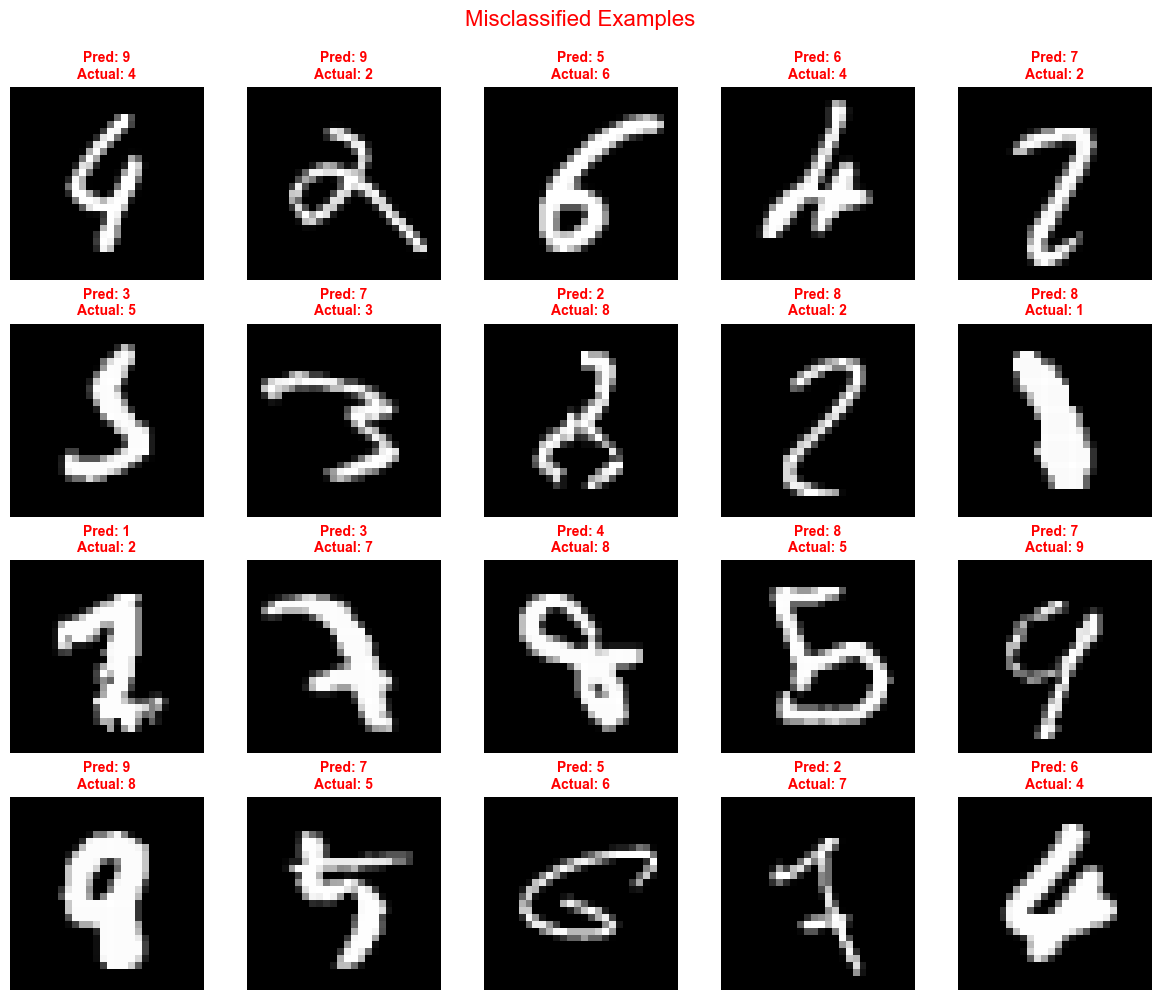


Showing 20 misclassified examples
These are cases where the model made mistakes.
Analyzing these can help identify patterns in model errors.


In [25]:
#@title Find and Display Misclassified Examples

# Collect misclassified examples
net.eval()
misclassified_images = []
misclassified_labels = []
misclassified_preds = []

with torch.no_grad():
    for images, labels in test_gen:
        images_flat = Variable(images.view(-1, 28*28))
        outputs = net(images_flat)
        _, predicted = torch.max(outputs.data, 1)
        
        # Find misclassified samples in this batch
        wrong_idx = (predicted != labels).nonzero(as_tuple=True)[0]
        
        for idx in wrong_idx:
            if len(misclassified_images) < 20:  # Collect up to 20 examples
                misclassified_images.append(images[idx].numpy())
                misclassified_labels.append(labels[idx].item())
                misclassified_preds.append(predicted[idx].item())
        
        if len(misclassified_images) >= 20:
            break

# Plot misclassified examples
if len(misclassified_images) > 0:
    num_examples = min(20, len(misclassified_images))
    rows = (num_examples + 4) // 5  # Calculate needed rows
    
    fig, axes = plt.subplots(rows, 5, figsize=(12, 2.5*rows))
    fig.suptitle('Misclassified Examples', fontsize=16, color='red', y=0.995)
    
    # Flatten axes if needed
    if rows == 1:
        axes = axes.reshape(1, -1)
    
    for idx, ax in enumerate(axes.flat):
        if idx < num_examples:
            # Display image
            ax.imshow(misclassified_images[idx].squeeze(), cmap='gray')
            
            # Set title with prediction and actual label
            title = f'Pred: {misclassified_preds[idx]}\nActual: {misclassified_labels[idx]}'
            ax.set_title(title, fontsize=10, color='red', weight='bold')
            ax.axis('off')
        else:
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f'\nShowing {num_examples} misclassified examples')
    print('These are cases where the model made mistakes.')
    print('Analyzing these can help identify patterns in model errors.')
else:
    print('No misclassified examples found in the test set!')


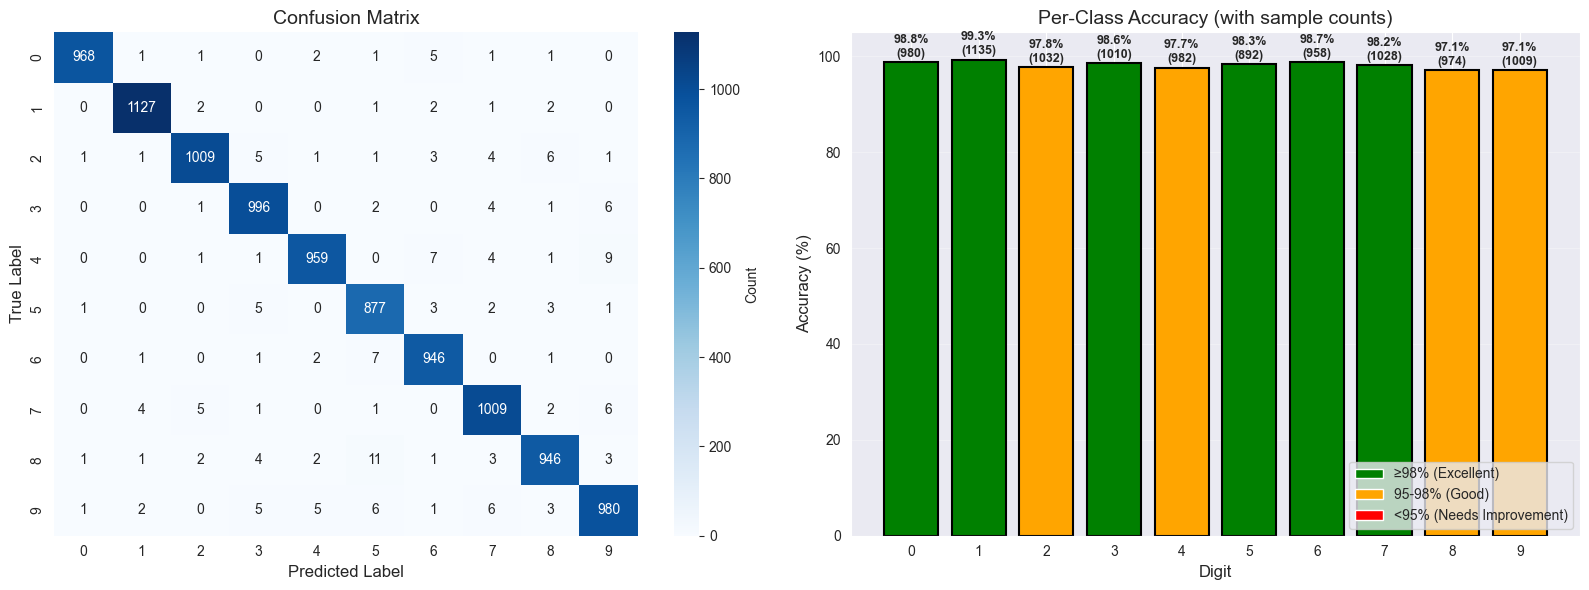


PER-CLASS PERFORMANCE
Digit    Accuracy     Correct/Total   Errors
------------------------------------------------------------
0         98.78%       968/980           12
1         99.30%      1127/1135           8
2         97.77%      1009/1032          23
3         98.61%       996/1010          14
4         97.66%       959/982           23
5         98.32%       877/892           15
6         98.75%       946/958           12
7         98.15%      1009/1028          19
8         97.13%       946/974           28
9         97.13%       980/1009          29

Overall Accuracy: 98.17%

Most Confused Pairs (where model makes mistakes):
1. Digit 8 misclassified as 5: 11 times
2. Digit 4 misclassified as 9: 9 times
3. Digit 4 misclassified as 6: 7 times
4. Digit 6 misclassified as 5: 7 times
5. Digit 2 misclassified as 8: 6 times


In [26]:
#@title Confusion Matrix and Per-Class Accuracy

from sklearn.metrics import confusion_matrix
import seaborn as sns

# Collect all predictions and labels
net.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for images, labels in test_gen:
        images_flat = Variable(images.view(-1, 28*28))
        outputs = net(images_flat)
        _, predicted = torch.max(outputs.data, 1)
        
        all_predictions.extend(predicted.numpy())
        all_labels.extend(labels.numpy())

all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# Create confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Calculate per-class accuracy
class_accuracies = []
class_totals = []
for digit in range(10):
    digit_mask = all_labels == digit
    digit_correct = (all_predictions[digit_mask] == digit).sum()
    digit_total = digit_mask.sum()
    class_totals.append(digit_total)
    accuracy = 100 * digit_correct / digit_total if digit_total > 0 else 0
    class_accuracies.append(accuracy)

# Plot confusion matrix and per-class accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1, cbar_kws={'label': 'Count'})
ax1.set_xlabel('Predicted Label', fontsize=12)
ax1.set_ylabel('True Label', fontsize=12)
ax1.set_title('Confusion Matrix', fontsize=14)

# Per-Class Accuracy
digits = list(range(10))
colors = ['green' if acc >= 98 else 'orange' if acc >= 95 else 'red' for acc in class_accuracies]
bars = ax2.bar(digits, class_accuracies, color=colors, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for i, (bar, acc, total) in enumerate(zip(bars, class_accuracies, class_totals)):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{acc:.1f}%\n({total})',
            ha='center', va='bottom', fontsize=9, weight='bold')

ax2.set_xlabel('Digit', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_title('Per-Class Accuracy (with sample counts)', fontsize=14)
ax2.set_ylim([0, 105])
ax2.set_xticks(digits)
ax2.grid(True, alpha=0.3, axis='y')

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='green', label='≥98% (Excellent)'),
    Patch(facecolor='orange', label='95-98% (Good)'),
    Patch(facecolor='red', label='<95% (Needs Improvement)')
]
ax2.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()

# Print statistics
print(f'\n{"="*60}')
print('PER-CLASS PERFORMANCE')
print(f'{"="*60}')
print(f'{"Digit":<8} {"Accuracy":<12} {"Correct/Total":<15} {"Errors"}')
print(f'{"-"*60}')
for digit in range(10):
    digit_mask = all_labels == digit
    digit_correct = (all_predictions[digit_mask] == digit).sum()
    digit_total = digit_mask.sum()
    digit_errors = digit_total - digit_correct
    accuracy = 100 * digit_correct / digit_total if digit_total > 0 else 0
    print(f'{digit:<8} {accuracy:>6.2f}%      {digit_correct:>4}/{digit_total:<8}    {digit_errors:>4}')

print(f'\n{"="*60}')
print(f'Overall Accuracy: {100 * (all_predictions == all_labels).sum() / len(all_labels):.2f}%')
print(f'{"="*60}')

print(f'\nMost Confused Pairs (where model makes mistakes):')
# Find most confused pairs
confused_pairs = []
for i in range(10):
    for j in range(10):
        if i != j and cm[i, j] > 0:
            confused_pairs.append((i, j, cm[i, j]))

confused_pairs.sort(key=lambda x: x[2], reverse=True)
for i, (true_label, pred_label, count) in enumerate(confused_pairs[:5]):
    print(f'{i+1}. Digit {true_label} misclassified as {pred_label}: {count} times')
